In [3]:
import os
import torch
import numpy as np
import collections
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import StratifiedGroupKFold
from tqdm import tqdm
import timm
import torch.nn as nn
import torch.optim as optim

In [11]:
DATA_ROOT = '/kaggle/input'
BATCH_SIZE = 32
IMG_SIZE = 224

# Explicitly map folder keywords to IDs
# We check these strings inside the file path.
FOLDER_TO_LABEL = {
    'Benign': 0,
    'Early': 1,   # Matches "Early Pre-B"
    'Pre': 2,     # Matches "Pre-B" (careful not to match "Early Pre" double)
    'Pro': 3      # Matches "Pro-B"
}

# Display names
CLASS_NAMES = {
    0: 'Benign', 
    1: 'Early Pre-B', 
    2: 'Pre-B', 
    3: 'Pro-B'
}

In [39]:
# 0 = CML, 1 = CLL, 2 = Acute (Merged)
FOLDER_TO_LABEL = {
    'Benign': 0,
    'Early Pre-B': 1,
    'Pre-B': 2,# Acute
    'Pro-B': 3  # Healthy
}

CLASS_NAMES = {0: 'CLL', 1: 'ALL(Pro)', 2: 'ALL(Pre)', 3:'Healthy'}

In [12]:
# ==========================================
# 2. ROBUST CRAWLER
# ==========================================
def find_images_strict(root_dir):
    paths = []
    labels = []
    print(f"🕵️ Scanning {root_dir}...")
    
    for root, dirs, files in os.walk(root_dir):
        # We check the folder path against our keywords
        root_lower = root.lower() # specific normalization
        
        detected_id = None
        
        # Priority Check (Longer names first to avoid confusion)
        if 'early' in root_lower:
            detected_id = 1
        elif 'pre' in root_lower:
            detected_id = 2
        elif 'pro' in root_lower:
            detected_id = 3
        elif 'benign' in root_lower:
            detected_id = 0
            
        # If we found a valid class
        if detected_id is not None:
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                    paths.append(os.path.join(root, file))
                    labels.append(detected_id)
                    
    return paths, labels

all_paths, all_labels = find_images_strict(DATA_ROOT)

print(f"\n✅ Total Images: {len(all_paths)}")
for i in range(4):
    print(f"   Class {i} ({CLASS_NAMES[i]}): {all_labels.count(i)}")

if len(all_paths) == 0: raise ValueError("No images found!")

🕵️ Scanning /kaggle/input...

✅ Total Images: 3242
   Class 0 (Benign): 512
   Class 1 (Early Pre-B): 979
   Class 2 (Pre-B): 955
   Class 3 (Pro-B): 796


In [13]:
print(f"Total Images Found: {len(all_paths)}")

Total Images Found: 3242


In [14]:
# ==========================================
# 3. BALANCED SPLIT (Per-Class)
# ==========================================
X_train, y_train = [], []
X_val, y_val = [], []
X_test, y_test = [], []

print("\n--- Splitting Each Class Separately ---")

for cls_idx in range(4):
    # Get files for this class
    cls_paths = [p for p, l in zip(all_paths, all_labels) if l == cls_idx]
    
    # Optional: Undersample if huge imbalance (>1500 images)
    if len(cls_paths) > 2000:
        random.shuffle(cls_paths)
        cls_paths = cls_paths[:2000]
        
    cls_groups = [os.path.dirname(p) for p in cls_paths]
    unique_patients = list(set(cls_groups))
    
    print(f"Class {cls_idx}: {len(cls_paths)} images | {len(unique_patients)} Patients")
    
    # LOGIC: If many patients, use GroupSplit. If few, use RandomSplit.
    if len(unique_patients) >= 4:
        # Train (70%)
        splitter = GroupShuffleSplit(test_size=0.30, n_splits=1, random_state=42)
        train_idx, temp_idx = next(splitter.split(cls_paths, groups=cls_groups))
        
        X_train.extend([cls_paths[i] for i in train_idx])
        y_train.extend([cls_idx] * len(train_idx))
        
        # Temp paths/groups for Val/Test
        temp_paths = [cls_paths[i] for i in temp_idx]
        temp_groups = [cls_groups[i] for i in temp_idx]
        
        # Val (15%) / Test (15%)
        splitter_val = GroupShuffleSplit(test_size=0.50, n_splits=1, random_state=42)
        val_idx, test_idx = next(splitter_val.split(temp_paths, groups=temp_groups))
        
        X_val.extend([temp_paths[i] for i in val_idx])
        y_val.extend([cls_idx] * len(val_idx))
        
        X_test.extend([temp_paths[i] for i in test_idx])
        y_test.extend([cls_idx] * len(test_idx))
    else:
        # Fallback for rare classes
        c_train, c_temp = train_test_split(cls_paths, test_size=0.30, random_state=42)
        c_val, c_test = train_test_split(c_temp, test_size=0.50, random_state=42)
        
        X_train.extend(c_train); y_train.extend([cls_idx]*len(c_train))
        X_val.extend(c_val); y_val.extend([cls_idx]*len(c_val))
        X_test.extend(c_test); y_test.extend([cls_idx]*len(c_test))

print("-" * 30)
print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

# Verify Validation Set isn't broken
val_counts = collections.Counter(y_val)
print(f"Val Distribution: {dict(val_counts)}")
if len(val_counts) < 4:
    print("❌ CRITICAL: Validation set is missing a class! Check the 'Class X' prints above.")
else:
    print("✅ Validation set has all 4 classes.")


--- Splitting Each Class Separately ---
Class 0: 512 images | 1 Patients
Class 1: 979 images | 1 Patients
Class 2: 955 images | 1 Patients
Class 3: 796 images | 1 Patients
------------------------------
Train: 2268 | Val: 486 | Test: 488
Val Distribution: {0: 77, 1: 147, 2: 143, 3: 119}
✅ Validation set has all 4 classes.


In [15]:
# --- 4. RAM-CACHED DATASET CLASS ---
class CachedDataset(Dataset):
    def __init__(self, file_paths, labels, img_size, mode="train"):
        self.paths = file_paths
        self.data = []  # Stores actual images in RAM
        self.labels = labels
        self.mode = mode
        
        # 1. DEFINE TRANSFORMS (Must happen for ALL modes)
        # ------------------------------------------------
        if mode == "train":
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(180),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            # This 'else' block ensures Validation/Test sets get a transform too
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

        # 2. LOAD IMAGES INTO RAM
        # ------------------------------------------------
        print(f"📥 Loading {mode} data into RAM ({len(file_paths)} images)...")
        resize_tool = transforms.Resize((img_size, img_size))
        
        for path in tqdm(file_paths):
            try:
                with Image.open(path) as img:
                    img = img.convert('RGB')
                    img_resized = resize_tool(img)
                    self.data.append(img_resized)
            except Exception as e:
                print(f"⚠️ Error loading {path}: {e}")
                # Fallback: Black image to prevent crash
                self.data.append(Image.new('RGB', (img_size, img_size)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Fetch image from RAM
        img = self.data[idx]
        label = self.labels[idx]
        
        # Apply the transform defined in __init__
        img = self.transform(img)
        
        return img, torch.tensor(label, dtype=torch.long)

# --- RE-INITIALIZE LOADERS ---
# You must re-run this part to apply the new Class definition
print("\nRe-creating DataLoaders...")

# Ensure these variables (X_train, y_train, etc.) exist from your previous split steps
train_ds = CachedDataset(X_train, y_train, IMG_SIZE, mode="train")
val_ds = CachedDataset(X_val, y_val, IMG_SIZE, mode="val")
test_ds = CachedDataset(X_test, y_test, IMG_SIZE, mode="test")

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("\n✅ DataLoaders Fixed. You can run training now.")


Re-creating DataLoaders...
📥 Loading train data into RAM (2268 images)...


100%|██████████| 2268/2268 [00:37<00:00, 61.29it/s]


📥 Loading val data into RAM (486 images)...


100%|██████████| 486/486 [00:08<00:00, 56.44it/s]


📥 Loading test data into RAM (488 images)...


100%|██████████| 488/488 [00:08<00:00, 57.10it/s]


✅ DataLoaders Fixed. You can run training now.


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm

# ==========================================
# 1. CONFIGURATION
# ==========================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LR = 5e-5               # Low learning rate for stability
WEIGHT_DECAY = 0.05     # Strong regularization
EPOCHS = 20

# ==========================================
# 2. BUILD REGULARIZED MODEL
# ==========================================
def build_model():
    print("Building Custom Swin Transformer (4 Classes: Benign, Early, Pre, Pro)...")
    
    # We use 'swin_tiny_patch4_window7_224' as the base
    model = timm.create_model(
        'swin_tiny_patch4_window7_224',
        pretrained=False,       # False because we are modifying the architecture
        num_classes=4,          # Matches your folder count
        
        
        # --- ANTI-OVERFITTING LAYERS ---
        drop_rate=0.3,          # Drops 30% of connections in final layer
        attn_drop_rate=0.2,     # Drops 20% of attention links
        drop_path_rate=0.2      # Randomly skips entire layers (Stochastic Depth)
    )
    return model.to(DEVICE)

# Initialize Model
model = build_model()

# ==========================================
# 3. LOSS & OPTIMIZER
# ==========================================
# Label Smoothing: Prevents the model from being "too confident" (e.g. predicting 100% prob)
# This forces it to learn more general features.
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# AdamW Optimizer: Best for Transformers
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Learning Rate Scheduler
# If validation loss stops improving for 3 epochs, cut the Learning Rate by 10x
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.1, 
    patience=3, 
    verbose=True
)

print("\n✅ Model, Optimizer, and Scheduler are ready.")
print(f"   - Device: {DEVICE}")
print(f"   - Learning Rate: {LR}")
print(f"   - Weight Decay: {WEIGHT_DECAY}")

Building Custom Swin Transformer (4 Classes: Benign, Early, Pre, Pro)...

✅ Model, Optimizer, and Scheduler are ready.
   - Device: cuda
   - Learning Rate: 5e-05
   - Weight Decay: 0.05


In [17]:
import torch
import numpy as np
from tqdm import tqdm

# ==========================================
# 4. TRAINING LOOP
# ==========================================
history = {
    'train_loss': [], 'val_loss': [], 
    'train_acc': [], 'val_acc': []
}
best_acc = 0.0

print(f"\n🚀 Starting Training for {EPOCHS} Epochs...")

for epoch in range(EPOCHS):
    # --- TRAIN PHASE ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Progress bar for this epoch
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    
    for inputs, targets in loop:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
        # Forward & Backward
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # Stats
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Update progress bar
        loop.set_postfix(loss=loss.item(), acc=100.*correct/total)
        
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    
    # --- VALIDATION PHASE ---
    model.eval()
    val_loss_accum = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            val_loss_accum += loss.item()
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()
            
    val_loss = val_loss_accum / len(val_loader)
    val_acc = 100. * val_correct / val_total
    
    # --- UPDATES ---
    # Update Learning Rate based on Validation Loss
    scheduler.step(val_loss)
    
    # Save History
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    # Print Epoch Summary
    print(f"Ep {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
    
    # Save Best Model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'swin_4class_best.pth')
        print(f"    🌟 New Best Model Saved! ({val_acc:.2f}%)")

print(f"\n✅ Training Complete. Best Validation Accuracy: {best_acc:.2f}%")


🚀 Starting Training for 20 Epochs...


Ep 1 | Train Loss: 1.2870 | Val Loss: 0.9635 | Train Acc: 45.59% | Val Acc: 61.93%
    🌟 New Best Model Saved! (61.93%)


Ep 2 | Train Loss: 1.0415 | Val Loss: 0.8215 | Train Acc: 60.67% | Val Acc: 73.46%
    🌟 New Best Model Saved! (73.46%)


Ep 3 | Train Loss: 0.9571 | Val Loss: 0.8282 | Train Acc: 66.40% | Val Acc: 70.58%


Ep 4 | Train Loss: 0.9109 | Val Loss: 0.7809 | Train Acc: 67.95% | Val Acc: 71.81%


Ep 5 | Train Loss: 0.8566 | Val Loss: 1.0644 | Train Acc: 72.31% | Val Acc: 60.29%


Ep 6 | Train Loss: 0.8393 | Val Loss: 0.6750 | Train Acc: 73.15% | Val Acc: 84.57%
    🌟 New Best Model Saved! (84.57%)


Ep 7 | Train Loss: 0.8307 | Val Loss: 0.8628 | Train Acc: 75.75% | Val Acc: 67.28%


Ep 8 | Train Loss: 0.7812 | Val Loss: 0.8179 | Train Acc: 78.48% | Val Acc: 77.16%


Ep 9 | Train Loss: 0.7090 | Val Loss: 0.6098 | Train Acc: 82.10% | Val Acc: 86.01%
    🌟 New Best Model Saved! (86.01%)


Ep 10 | Train Loss: 0.6876 | Val Loss: 0.6249 | Train Acc: 83.25% | Val Acc: 84.57%


Ep 11 | Train Loss: 0.6778 | Val Loss: 0.5416 | Train Acc: 83.02% | Val Acc: 90.74%
    🌟 New Best Model Saved! (90.74%)


Ep 12 | Train Loss: 0.6773 | Val Loss: 0.6305 | Train Acc: 83.95% | Val Acc: 86.01%


Ep 13 | Train Loss: 0.6028 | Val Loss: 0.6419 | Train Acc: 87.61% | Val Acc: 87.24%


Ep 14 | Train Loss: 0.5782 | Val Loss: 0.5818 | Train Acc: 88.49% | Val Acc: 89.09%


Ep 15 | Train Loss: 0.5676 | Val Loss: 0.5061 | Train Acc: 89.33% | Val Acc: 90.95%
    🌟 New Best Model Saved! (90.95%)


Ep 16 | Train Loss: 0.5470 | Val Loss: 0.5781 | Train Acc: 90.30% | Val Acc: 88.48%


Ep 17 | Train Loss: 0.5441 | Val Loss: 0.5564 | Train Acc: 90.70% | Val Acc: 88.07%


Ep 18 | Train Loss: 0.5548 | Val Loss: 0.5284 | Train Acc: 90.39% | Val Acc: 91.77%
    🌟 New Best Model Saved! (91.77%)


Ep 19 | Train Loss: 0.5349 | Val Loss: 0.5190 | Train Acc: 90.74% | Val Acc: 90.53%


Ep 20 | Train Loss: 0.5031 | Val Loss: 0.4609 | Train Acc: 92.24% | Val Acc: 96.09%
    🌟 New Best Model Saved! (96.09%)

✅ Training Complete. Best Validation Accuracy: 96.09%


In [19]:
# --- 7. FINAL TEST EVALUATION ---
print("\n--- Running Final Test Set Evaluation ---")
model.load_state_dict(torch.load('swin_4class_best.pth'))
model.eval()

test_correct = 0
test_total = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in tqdm(test_loader, desc="Testing"):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        test_total += targets.size(0)
        test_correct += predicted.eq(targets).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

print(f"Final Test Accuracy: {100. * test_correct / test_total:.2f}%")


--- Running Final Test Set Evaluation ---


Testing: 100%|██████████| 16/16 [00:02<00:00,  6.86it/s]

Final Test Accuracy: 95.08%


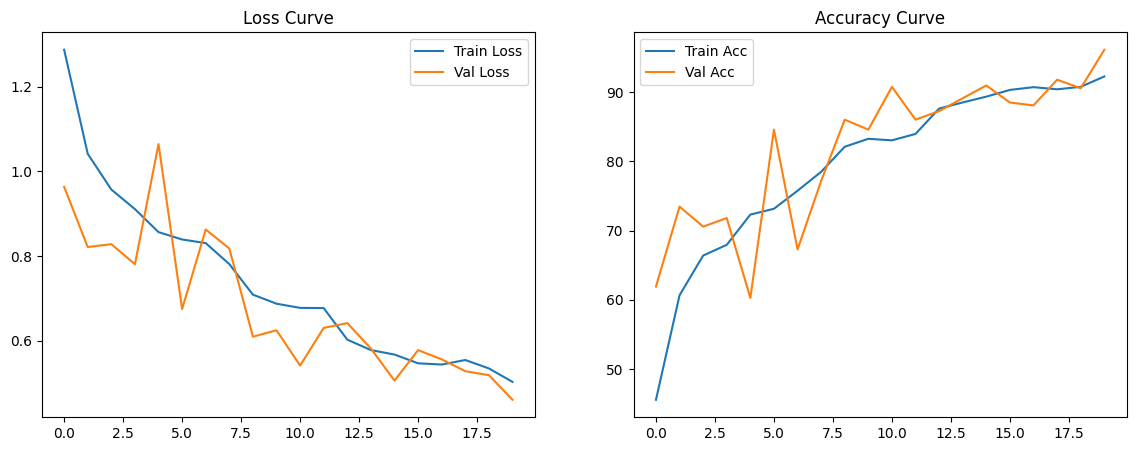

In [20]:
import matplotlib.pyplot as plt
# --- 8. PLOTTING ---
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(history['train_loss'], label='Train Loss')
ax[0].plot(history['val_loss'], label='Val Loss')
ax[0].set_title('Loss Curve')
ax[0].legend()

ax[1].plot(history['train_acc'], label='Train Acc')
ax[1].plot(history['val_acc'], label='Val Acc')
ax[1].set_title('Accuracy Curve')
ax[1].legend()
plt.show()

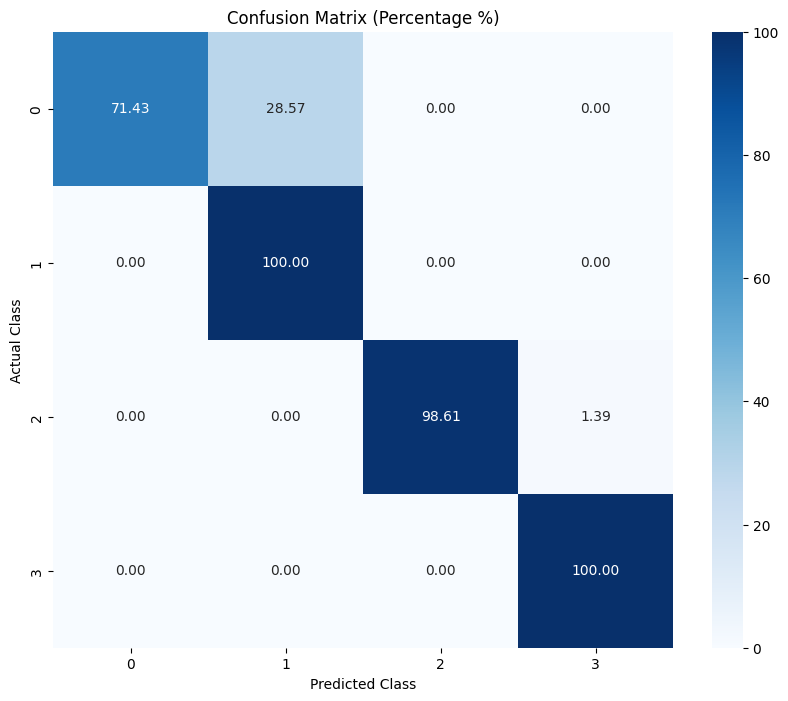

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Calculate the standard Confusion Matrix (Counts)
cm = confusion_matrix(all_targets, all_preds)

# 2. Convert to Percentages (Row-Wise Normalization)
# We divide each value by the sum of its row (Actual Class Total)
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# 3. Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm_pct, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)

# Add labels to make it clear
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix (Percentage %)')
plt.show()


Running t-SNE...
Extracting features from validation set...
Final Feature Shape: (486, 768)


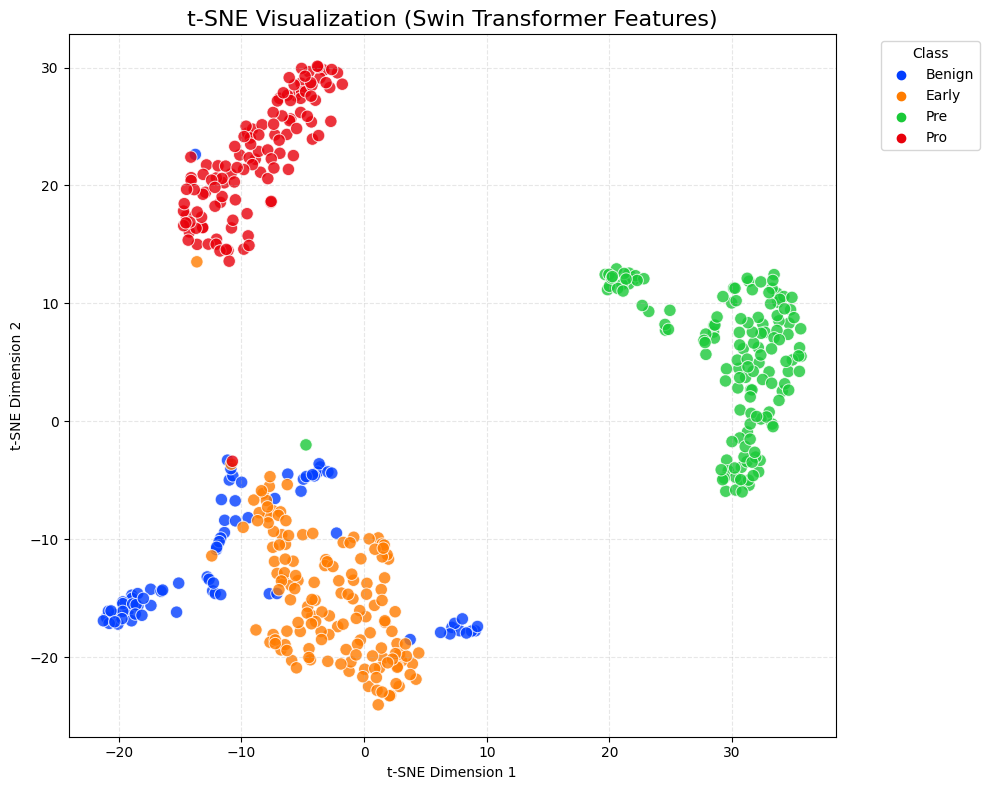

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import torch
import torch.nn as nn

# ==========================================
# 7. t-SNE VISUALIZATION (Fixed for Swin)
# ==========================================
print("\nRunning t-SNE...")

# 1. SETUP FEATURE EXTRACTOR
original_head = model.head 
model.head = nn.Identity() 

model.eval()
all_features = []
all_labels = []

print("Extracting features from validation set...")
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(DEVICE)
        
        # Swin Output Shape: [Batch, H, W, C] (e.g., [32, 7, 7, 768])
        features = model(inputs)
        
        # --- FIX: Apply Global Average Pooling ---
        # If output is 4D, we pool spatial dims to get [Batch, C]
        if features.ndim == 4:
            # Swin (timm) typically outputs (B, H, W, C), so we mean over dim 1 and 2
            # If your model outputs (B, C, H, W), change to dim=(2, 3)
            features = features.mean(dim=(1, 2)) 
        
        # Now shape is [Batch, 768] (Flat vector)
        all_features.append(features.cpu().numpy())
        all_labels.append(targets.numpy())

# Restore head
model.head = original_head

# 2. PREPARE DATA
X_feats = np.concatenate(all_features, axis=0)
y_true = np.concatenate(all_labels, axis=0)

# Double check shape (should be 2D now)
print(f"Final Feature Shape: {X_feats.shape}")
# If it's still not 2D for some reason, force flatten it:
if X_feats.ndim > 2:
    X_feats = X_feats.reshape(X_feats.shape[0], -1)

# 3. COMPUTE t-SNE
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
X_embedded = tsne.fit_transform(X_feats)

# 4. PLOT RESULTS
class_names = ['Benign', 'Early', 'Pre', 'Pro'] # Update to match your actual classes
y_true_names = [class_names[i] for i in y_true]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_embedded[:, 0], 
    y=X_embedded[:, 1], 
    hue=y_true_names, 
    palette='bright', 
    s=80, 
    alpha=0.8
)

plt.title('t-SNE Visualization (Swin Transformer Features)', fontsize=16)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [23]:
import torch
import os

# --- Define explicit path to Kaggle Output Directory ---
save_path = '/kaggle/working/swin_transformer_all.pth'

# --- Save the weights ---
torch.save(model.state_dict(), save_path)

print(f"✅ Model weights saved successfully to: {save_path}")

# --- Verify the file exists ---
if os.path.exists(save_path):
    file_size = os.path.getsize(save_path) / (1024 * 1024)
    print(f"   File Size: {file_size:.2f} MB")
    
    print("\n📂 Content of /kaggle/working/:")
    print(os.listdir("/kaggle/working"))

✅ Model weights saved successfully to: /kaggle/working/swin_transformer_all.pth
   File Size: 105.06 MB

📂 Content of /kaggle/working/:
['swin_regularized_best.pth', 'swin_4class_best.pth', 'swin_transformer_all.pth', '.virtual_documents']


In [24]:
import torch
import os
import copy
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [25]:
client_1_path = '/kaggle/input/all-healthy/pytorch/default/1/swin_transformer_fl_weights.pth'
client_2_path = '/kaggle/working/swin_transformer_all.pth'
global_model_path = 'Global_Federated_Model.pth'

In [26]:
# ==========================================
# 2. FEDERATED AVERAGING (The "Server" Logic)
# ==========================================
def federated_average(weight_paths, output_path):
    """
    Loads weights from multiple clients, averages them, and saves the Global Model.
    """
    print(f"\n🔄 STARTING AGGREGATION from: {weight_paths}")
    
    # 1. Load the first client's weights as a "base"
    if not os.path.exists(weight_paths[0]):
        raise FileNotFoundError(f"❌ Cannot find file: {weight_paths[0]}")
        
    global_weights = torch.load(weight_paths[0], map_location='cpu')
    
    # 2. Add up weights from all other clients
    for i in range(1, len(weight_paths)):
        if not os.path.exists(weight_paths[i]):
            raise FileNotFoundError(f"❌ Cannot find file: {weight_paths[i]}")
            
        client_weights = torch.load(weight_paths[i], map_location='cpu')
        
        for key in global_weights:
            global_weights[key] += client_weights[key]
            
    # 3. Divide by number of clients to get the Average
    n_clients = len(weight_paths)
    for key in global_weights:
        global_weights[key] = global_weights[key] / n_clients
        
    # 4. Save the new Global Model
    torch.save(global_weights, output_path)
    print(f"✅ Aggregation Complete. Global Model saved to: {output_path}")
    return output_path

In [27]:
# ==========================================
# 3. RELIABILITY TESTING (Using YOUR test_loader)
# ==========================================
def test_reliability(model_path, loader):
    print(f"\n⚖️ TESTING RELIABILITY on {len(loader.dataset)} Test Images...")
    
    # 1. Re-build the model architecture
    # (Using the build_model function from your previous code)
    model = build_model() 
    
    # 2. Load the Aggregated Global Weights
    model.load_state_dict(torch.load(model_path))
    model.to(DEVICE)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    # 3. Evaluation Loop
    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc="Evaluating Global Model"):
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.numpy())
            
    # 4. Generate Report
    # Ensure CLASS_NAMES matches your labels: 0=CML, 1=CLL, 2=Acute, 3=Healthy
    class_names_list = ["CML", "CLL", "Acute (Pro)", "Healthy"]
    
    print("\n" + "="*50)
    print("       FEDERATED GLOBAL MODEL RESULTS       ")
    print("="*50)
    print(classification_report(all_labels, all_preds, target_names=class_names_list))
    
    # 5. Plot Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names_list, yticklabels=class_names_list)
    plt.title("Reliability Check: Global Model vs Test Data")
    plt.ylabel("Actual Label")
    plt.xlabel("Predicted Label")
    plt.show()